In [139]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
from scipy import special
import pandas as pd
import h5py

def read_data(model_name, relax_time, time_step, total_time=100):
    line_width = 5e3 #The width of the line (a mesh with infinite points would need 0 width)
    
    #construct path string
    path = "../"+str(model_name)+"/Analysis/"+str(total_time)+"yrs_relax="+str(relax_time)+"_"+str(time_step)+".csv"
    
    model_output_df = pd.read_csv(path)
    
    #select rows from the dataframe where y is less then the specified width
    x_line = model_output_df.loc[(model_output_df['Points_1'] < line_width) & (model_output_df['Points_1'] > 0)]
    
    x = np.asarray(x_line['Points_0'])
    disp_x = np.asarray(x_line['displacement_0'])
    disp_y = np.asarray(x_line['displacement_1'])
    disp_z = np.asarray(x_line['displacement_2'])
    vel_x = np.asarray(x_line['velocity_0'])
    vel_y = np.asarray(x_line['velocity_1'])
    vel_z = np.asarray(x_line['velocity_2'])
    
    return (x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z)

def read_h5(model_name, relax_time, time_step, total_time=100):
    
    #dictionary to be updated with the name of the file and the 'model name' given
    file_names = {"ViscoelasticSandwich/10km": "ViscoelasticSandwich",
                  "ViscoelasticSandwich/15km": "ViscoelasticSandwich", 
                   "SMB/NoCyl": "SMB_noCyl"}
    
    line_width = 5e3 #The width of the line (a mesh with infinite points would need 0 width)
    
    #get the file path
    path = "../"+str(model_name)+"/output/" + file_names[model_name] + "-groundsurf-100_"+str(relax_time)+"_yr_relax.h5" 
    
    #prepare lists for getting data from hdf5 files
    with h5py.File(path, "r") as f:
            
        #Get the HDF5 groups
        group_geometry = f['geometry']
        group_vert_fields = f['vertex_fields']
        
        points = group_geometry['vertices'] #shape: point_num, xyz
        displacements = group_vert_fields['displacement'] #shape: timestep, point_num, xyz
        velocities = group_vert_fields['velocity'] #shape: timestep, point_num, xyz
        
        x_line_indices = np.where((points[:,1] > 0) & (points[:,1] < line_width)) #get indices for the xline
        
        #get data from the hdf5 file with the indices
        x = points[x_line_indices][:,0]
        
        disp_x = displacements[time_step][ x_line_indices][:,0]
        disp_y = displacements[time_step][ x_line_indices][:,1]
        disp_z = displacements[time_step][ x_line_indices][:,2]
        
        vel_x = velocities[time_step][ x_line_indices][:,0]
        vel_y = velocities[time_step][ x_line_indices][:,1]
        vel_z = velocities[time_step][ x_line_indices][:,2]
        
    return (x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z)

#function to sort x and disp data for plotting
def sort_x_disp(x, disp):
    xs, ys = zip(*sorted(zip(x, disp)))

    return (np.asarray(xs), np.asarray(ys))


In [142]:
#plot surface displacements over time for a given model
def surface_vert_disp_time(model_name, time_steps, relax_time, dt, plot_title_name=None):
    
    #set up plot for uz
    plt.grid()
    plt.xlabel('Distance from center (km)')
    plt.ylabel('Vertical Displacement (m)')
    if plot_title_name == None:
        plt.title("Vertical Surface Displacements for "+ model_name + r",  $\tau$="+str(relax_time))
    else:
        plt.title("Vertical Surface Displacements for "+ plot_title_name + r",  $\tau$="+str(relax_time))
    
    #iterate through time steps
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t) #get data
        
        #sort x and disp z
        x, disp_z = sort_x_disp(x, disp_z)
        #plot the data
        plt.scatter(x/1e3, disp_z, label="time="+str(t), s=5)
        plt.plot(x/1e3, disp_z)
        
    plt.legend()
    plt.show()
    
    
def displacement_velocity_plots(model_name, time_steps, relax_time, dt, plot_title_name=None):
    
    #collect max uz, ur, vz, vr
    uz_max = []
    ur_max = []
    vz_max = []
    vr_max = []
    
    uz_norm = 1
    ur_norm = 1
    vz_norm = 1
    vr_norm = 1
    for t in time_steps:
        x, disp_x, disp_y, disp_z, vel_x, vel_y, vel_z = read_h5(model_name, relax_time, t) #get data
        
        uz_max.append(max(disp_z))
        ur_max.append(max(disp_x))
        
        if t != 0:
            vz_max.append(vel_z[list(disp_z).index(max(disp_z))])
            vr_max.append(vel_x[list(disp_x).index(max(disp_x))])
         
        #normalize by elastic response
        if t==0:
            uz_norm = max(disp_z)
            ur_norm = max(disp_x)
            vz_norm = max(vel_z)
            vr_norm = max(vel_x)
            
    
    #set up subplots for displacement
    fig, ax = plt.subplots(2)
    ax[0].set_ylabel(r"Normalized max $u_z(r)$")
    ax[1].set_ylabel(r"Normalized max $u_x(r)$")
    ax[1].set_xlabel("Time (years)")
    ax[0].grid()
    ax[1].grid()
    
    if plot_title_name == None:
        ax[0].set_title("Normalized Maximum Displacements for "+ model_name+ r",  $\tau$="+str(relax_time))
    else:
        ax[0].set_title("Normalized Maximum Displacements for "+ plot_title_name+ r",  $\tau$="+str(relax_time))
     
    #plot displacements
    ax[0].scatter(time_steps, np.asarray(uz_max)/uz_norm)
    ax[0].plot(time_steps, np.asarray(uz_max)/uz_norm)
    
    ax[1].scatter(time_steps, np.asarray(ur_max)/ur_norm)
    ax[1].plot(time_steps, np.asarray(ur_max)/ur_norm)
    
    
     #set up subplots for velocity
    fig, ax = plt.subplots(2)
    ax[0].set_ylabel(r"Normalized $v_z(r)$")
    ax[1].set_ylabel(r"Normalized $v_x(r)$")
    ax[1].set_xlabel("Time (years)")
    ax[0].grid()
    ax[1].grid()
    
    if plot_title_name == None:
        ax[0].set_title("Normalized Velocities of the maximum displacements for "+ model_name+ r",  $\tau$="+str(relax_time))
    else:
        ax[0].set_title("Normalized Velocities of the maximum displacements for "+ plot_title_name+ r",  $\tau$="+str(relax_time))
     
    #plot velocities
    time_steps_copy = time_steps.copy()
    time_steps_copy.remove(0)
    ax[0].scatter(time_steps_copy, np.asarray(vz_max)/vz_norm)
    ax[0].plot(time_steps_copy, np.asarray(vz_max)/vz_norm)
    
    ax[1].scatter(time_steps_copy, np.asarray(vr_max)/vr_norm)
    ax[1].plot(time_steps_copy, np.asarray(vr_max)/vr_norm)
        
    
        

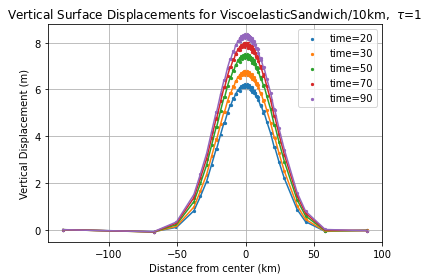

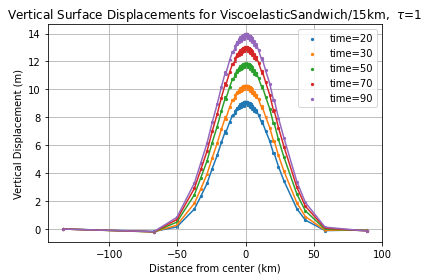

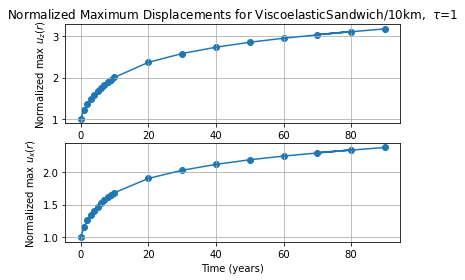

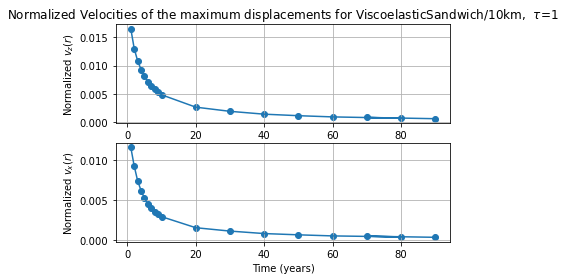

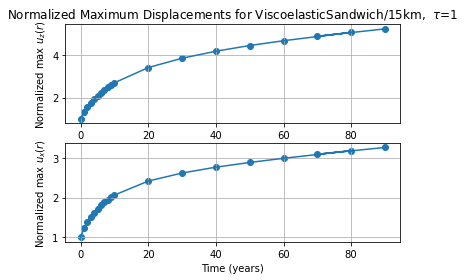

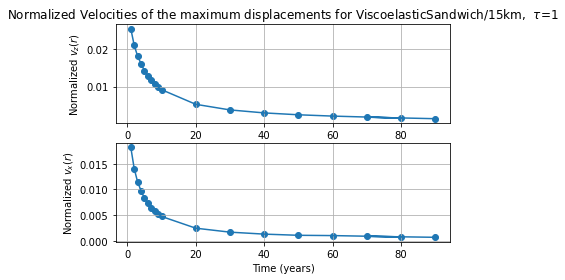

In [144]:
time_steps = [20, 30, 50, 70, 90]

surface_vert_disp_time("ViscoelasticSandwich/10km", time_steps, 1, 1)
surface_vert_disp_time("ViscoelasticSandwich/15km", time_steps, 1, 1)

time_steps = [0, 1, 2, 3,4 , 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 80, 70, 90]

displacement_velocity_plots("ViscoelasticSandwich/10km", time_steps, 1, 1)
displacement_velocity_plots("ViscoelasticSandwich/15km", time_steps, 1, 1)